In [90]:
import datetime, urllib, re, math, json, requests,io
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy import optimize
from sklearn.linear_model import LinearRegression
from IPython.display import display, HTML



try:
    from packaging import version
except ImportError:
    !pip install packaging

if( version.parse(pd.__version__) < version.parse("0.23.4")):
    print("update pandas")
    !pip install pandas --upgrade #--ignore-installed
    print(version.parse(pd.__version__))
#might need this
#!pip install --upgrade pip    

# Constants

In [91]:
#** pandas
# change max number of rows to show
pd.set_option('display.max_rows', 300)

#** plotters formats

import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from cycler import cycler
#* dpi size
plt.rcParams['figure.dpi'] = 200
myFmt = mdates.DateFormatter('%m/%d')
myLocator = mticker.MultipleLocator(7)

default_cycler = (cycler(marker=['.','*','+','s','x']) *
                  cycler(color=['b','g','k','m','y','c','r']) *
                  cycler(linestyle=['-']))

plt.rc('axes', prop_cycle=default_cycler)

#** panda data frame styles
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

    
def setupAxis(ax,title):
    ax.xaxis.set_major_locator(myLocator)
    ax.grid()
    ax.xaxis.set_major_formatter(myFmt)
    ax.legend()
    ax.set_title(title);
    

# CDC Data 

## URL to the data base

html --> https://www.cdc.gov/coronavirus/2019-ncov/cases-in-us.html    
json --> https://www.cdc.gov/coronavirus/2019-ncov/us-cases-epi-chart.json

In [92]:
#using cdc data direclty for the US


url = "https://www.cdc.gov/coronavirus/2019-ncov/us-cases-epi-chart.json"

r = requests.get(url)
jdata =r.json()

# get x/y's
x = jdata["data"]["columns"][0][1:]
X = [datetime.datetime.strptime(d,"%m/%d/%Y").date() for d in x] # x's
v = jdata["data"]["columns"][1][1:] # v's (new cases fo the day)

# interpolate the zeros, since nearly impossible to have no growth
V = pd.Series(np.array(v).astype('int'))
V[V==0]=np.nan #
V = V.interpolate()
if(0): #check data
    print(list(zip(X,V)))
# Remove fist zeros
offsetZero = V.notna().idxmax()
V = V.values[offsetZero:]
X = X[offsetZero:]    

# convert new cases (v) to cumulative cases(y)
dataCdc = pd.Series(V,X).cumsum()
dataCdc[-5:]

2020-03-16    3908.0
2020-03-17    3998.0
2020-03-18    4042.0
2020-03-19    4063.0
2020-03-20    4065.0
dtype: float64

# Domestic/internation number of cases by john hopkins data base
## gui 

https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

## github 

https://github.com/CSSEGISandData/COVID-19

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series

In [93]:
idx = pd.IndexSlice
      
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
#      "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"

files = ["time_series_covid19_confirmed_global.csv"]
file = files[0]
link =URL+file


#read csv can read urls directly
df = pd.read_csv(link,parse_dates=True)
# set row indices, only have dates for columns ids, set Na for np.NaN (very annoying)
df[["Lat","Long","Province/State"]]=df[["Lat","Long","Province/State"]].fillna("NA")
data=df.copy()
data.set_index(["Country/Region","Province/State","Lat","Long"], inplace=True)
# use before set index , create coutnry sum,
#note this is an over-estimate for us
for ctr in data.index.levels[0].unique() :
    cnt = data.loc[idx[ctr ,:,:,:],:].count()[0]
    if not cnt>1: continue
    print(ctr)
    data.loc[idx[ctr,"NA","NA","NA"],:] =df[
            (~df["Province/State"].str.contains('NA')) &
            (~df["Province/State"].str.contains(','))  &
            (df["Country/Region"]==ctr) ].sum()




#print(data.loc[idx["US","NA","NA","NA"],:].sum())

data.columns = pd.to_datetime(data.columns,format="%m/%d/%y")

dt = data.columns[-1]
print(dt)
if sum(data[dt].apply(math.isnan)):
    print("missing samples go back one day")
    data.drop(columns=dt,inplace=True) 
    dt = data.columns[-2]
if((datetime.datetime.today()-dt).days>1):
    print("***error***")
#create a no china row, all china and all US

#create a no china row, all china and all US
noChin = data.index.levels[0][data.index.levels[0]!="China"]
data.loc["NoChina","NA","NA","NA"]=data.loc[(noChin)].sum()   


dataJHU = data.copy()


Australia
Canada
China
Denmark
France
Netherlands
United Kingdom
2020-04-07 00:00:00


In [94]:
#info on styles here
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
import seaborn as sns

dt = dataJHU.columns[-1]
N=5000
# find rows with NA for province/state
#g =dataJHU.filter(like="NA",axis=0)
# find countries with large case counts
g = dataJHU.loc[idx[:,"NA",:,:],:]
g = g[g[dt]>N]

#creat3ea a focus data set
dataFocus = pd.DataFrame()
dataFocus[dataJHU.columns[-1]] = g.loc[(g[dt]>N),  (dataJHU.columns[-1])]
dataFocus[dataJHU.columns[-2]] = g.loc[(g[dt]>N),  (dataJHU.columns[-2])]
dataFocus["delta"]             = g.loc[:,(g.columns[-1])]-dataJHU.loc[:,g.columns[-2]]
dataFocus["delta%"]            = dataFocus["delta"] / g.loc[:,(g.columns[-1])]
dataFocus=dataFocus.reset_index().drop(columns=["Lat",'Long',"Province/State"]).set_index("Country/Region")

# gradient across two colols, second is one color
cm = sns.diverging_palette(150,10, n=12,l=55,center='light',as_cmap=True)
cm = sns.light_palette('red',as_cmap=True)

display(dataFocus.sort_values(by="delta",ascending=False).style
    .background_gradient(cmap=cm, subset=['delta%'])
    .format({'delta%': "{:.1%}"})
    )



dataStates= pd.DataFrame()
dataStates[dataJHU.columns[-1]]=dataJHU.loc[idx["US",:,:,:],:].sort_values(by=dt,ascending=False)[dataJHU.columns[-1]]
dataStates[dataJHU.columns[-2]]=dataJHU.loc[idx["US",:,:,:],:].sort_values(by=dt,ascending=False)[dataJHU.columns[-2]]
dataStates["delta"]  = dataStates[dataJHU.columns[-1]]- dataStates[dataJHU.columns[-2]]
dataStates["delta%"] = dataStates["delta"] / dataStates[dataJHU.columns[-1]]
dataStates=dataStates.reset_index().drop(columns=["Lat",'Long']).set_index("Country/Region","Province/State")

# create list of countires to focus on for later processing
countriesFocused = [dataJHU.index.levels[0][i] for i in g.index.labels[0]]
countriesFocused = countriesFocused+["Japan"];


,2020-04-07 00:00:00,2020-04-06 00:00:00,delta,delta%
Country/Region,,,,
NoChina,1.36917e+06,1.28674e+06,82435,6.0%
US,396223,366667,29556,7.5%
France,109069,98010,11059,10.1%
Spain,141942,136675,5267,3.7%
Germany,107663,103374,4289,4.0%
Turkey,34109,30217,3892,11.4%
United Kingdom,55242,51608,3634,6.6%
Italy,135586,132547,3039,2.2%
Iran,62589,60500,2089,3.3%


# 3rd party data, but more reliable and better format compared to JHU,

open source and peer review

In [95]:
df = pd.read_csv("https://coronadatascraper.com/timeseries-tidy.csv")
df.fillna("NA",inplace=True);
dataTCS =df.set_index(["city","county","state","country","type"])

# 3rd party data source real time data, from a spin of JHU
http://blog.lazd.net/coronadatascraper/

In [96]:
idx = pd.IndexSlice
df = pd.read_csv("http://coronadatascraper.com/data.csv",parse_dates=True)
df[["city","county","state","country"]] =df[["city","county","state","country"]]
dataCS =df.set_index(["city","county","state","country","level"])

# example access
IClmns= idx["cases","death","recovered","tested",'url']
ctrMask = dataCS["cases"] > 1e4
dataCS.loc[idx[:,:,:,ctrMask,"country"],IClmns].sort_values(by="cases",ascending=False)

cases  death  recovered  \
city county state country        level                                 
NaN  NaN    NaN   United States  country  393698.0    NaN        NaN   
                  Spain          country  140510.0    NaN    43208.0   
                  Italy          country  133775.0    NaN    24056.0   
                  Germany        country  107663.0    NaN    36081.0   
                  China          country   81739.0    NaN    77184.0   
                  France         country   78167.0    NaN    19336.0   
                  Iran           country   62589.0    NaN    27039.0   
                  United Kingdom country   55242.0    NaN      135.0   
                  Turkey         country   34109.0    NaN     1582.0   
                  Switzerland    country   22253.0    NaN     8704.0   
                  Belgium        country   22194.0    NaN     4157.0   
                  Netherlands    country   19580.0    NaN      250.0   
                  Canada         country   17883.0    NaN        NaN   
                  Brazil         country   13717.0    NaN        NaN   
                  Austria        country   12639.0    NaN     4046.0   
                  Portugal       country   12442.0    NaN      184.0   
                  South Korea    country   10331.0    NaN     6694.0   

                                             tested  \
city county state country        level                
NaN  NaN    NaN   United States  country  2080758.0   
                  Spain          country        NaN   
                  Italy          country   737684.0   
                  Germany        country        NaN   
                  China          country        NaN   
                  France         country        NaN   
                  Iran           country        NaN   
                  United Kingdom country        NaN   
                  Turkey         country        NaN   
                  Switzerland    country        NaN   
                  Belgium        country        NaN   
                  Netherlands    country        NaN   
                  Canada         country        NaN   
                  Brazil         country        NaN   
                  Austria        country        NaN   
                  Portugal       country        NaN   
                  South Korea    country        NaN   

                                                                                        url  
city county state country        level                                                       
NaN  NaN    NaN   United States  country               https://covidtracking.com/api/states  
                  Spain          country  https://github.com/datadista/datasets/tree/mas...  
                  Italy          country  https://raw.githubusercontent.com/pcm-dpc/COVI...  
                  Germany        country         https://github.com/CSSEGISandData/COVID-19  
                  China          country         https://github.com/CSSEGISandData/COVID-19  
                  France         country  https://raw.githubusercontent.com/opencovid19-...  
                  Iran           country         https://github.com/CSSEGISandData/COVID-19  
                  United Kingdom country         https://github.com/CSSEGISandData/COVID-19  
                  Turkey         country         https://github.com/CSSEGISandData/COVID-19  
                  Switzerland    country         https://github.com/CSSEGISandData/COVID-19  
                  Belgium        country         https://github.com/CSSEGISandData/COVID-19  
                  Netherlands    country         https://github.com/CSSEGISandData/COVID-19  
                  Canada         country  https://health-infobase.canada.ca/src/data/cov...  
                  Brazil         country                        https://covid.saude.gov.br/  
                  Austria        country         https://github.com/CSSEGISandData/COVID-19  
                  Portugal      

In [97]:
idx = pd.IndexSlice

# must have colons liberally used, firt two colons for city/county and last colon for all columns
# for access, using idx must have colons liberally used, firt two colons for city/county and last colon for all columns
dataCS.loc[idx[:, "San Diego County", "California", "United States","county"],IClmns]
#total cases in ca
dataCS.loc[idx[:,:, "California", "United States","state"],:]["cases"]
display(HTML(dataCS.loc[idx[:, :, "California", "United States","county"],IClmns].sort_values("cases",ascending=False).to_html()))

dataCS.loc[idx[:, "San Diego County", "California", "United States","county"],["url"]].values

array([['https://docs.google.com/spreadsheets/d/1CwZA4RPNf_hUrwzNLyGGNHRlh1cwl8vDHwIoae51Hac/gviz/tq?tqx=out:csv&sheet=master']],
      dtype=object)

# Testing numbers by Covid tracking (US only)

https://covidtracking.com

In [98]:
def get_csv_from_url(link):
    response = requests.get(link)
    
    file_object = io.StringIO(response.content.decode('utf-8'))
    return pd.read_csv(file_object)
#not PosNeg is total count subtracting pending

# us daily data -->
links=\
 ["https://covidtracking.com/api/us.csv",     # US current
 "http://covidtracking.com/api/us/daily.csv", # time series  
 "https://covidtracking.com/api/states.csv",  # state current
  "https://covidtracking.com/api/states/daily.csv"] # state time series

# how to get state data time series -->
# "https://covidtracking.com/api/states/daily?state=CA",#states
# "https://covidtracking.com/api/states/daily?state=NY",
dataCovTr = get_csv_from_url(links[0]);
dfUST     = get_csv_from_url(links[1]);
dfStates  = get_csv_from_url(links[2]);
dfTStates = get_csv_from_url(links[3]);

ts = pd.to_datetime(dfUST["date"],format="%Y%m%d")
dfUST.drop("date",axis=1,inplace=True)
dfUST.set_index(ts, inplace=True)

ts = pd.to_datetime(dfTStates["date"],format="%Y%m%d")
dfTStates.drop("date",axis=1,inplace=True)
dfTStates.set_index(ts, inplace=True)


In [99]:
# remove na from us time  series
dfUST["Case Delta"]=dfUST.sort_values(by="date",axis=0)["positive"].diff().fillna(-1)
dfUST["Test Delta"]=dfUST.sort_values(by="date",axis=0)["totalTestResults"]   .diff().fillna(-1)


# add negative rate for states current
dfStates["NegRate%"]=dfStates["negative"]/dfStates["totalTestResults"] * 100
dfUST   ["NegRate%"]=dfUST   ["negative"]/dfUST   ["totalTestResults"] * 100


display(HTML(dataCovTr.to_html()))
display(HTML(dfUST.sort_values('date',axis=0, ascending=False).head(7).to_html()))
display(HTML(
    dfTStates.loc[dfTStates.index[0]].sort_values(by="positive",ascending=False).head(12).to_html()))


,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,lastModified,death,hospitalized,total,totalTestResults,posNeg,notes
0,423164,1766602,17228,43524,47159,9702,1013,4073,216,19248,ec6a28ab7e379f4a8e5ac51dedb1f8c2c3d9cd29,2020-04-08T21:15:12.132Z,14495,47159,2206994,2189766,2189766,"NOTE: ""total"", ""posNeg"", ""hospitalized"" will b..."


,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,Case Delta,Test Delta,NegRate%
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-08,56,423164,1766602,17228,43524.0,47159.0,9702.0,1013.0,4073.0,216.0,19248.0,b94e7fa26773db33d584547f0a8d594ff8a1258d,2020-04-08T20:00:00Z,14495,47159.0,2206994,2189766,2189766,1874.0,1579.0,104734.0,30570.0,135304.0,30570.0,135304.0,80.675378
2020-04-07,56,392594,1661868,16557,39011.0,45580.0,9649.0,889.0,4007.0,233.0,17809.0,4e71b6d46d806fcc3658c5c3ddd97768bc6df407,2020-04-07T20:00:00Z,12621,45580.0,2071019,2054462,2054462,1941.0,730.0,114842.0,31263.0,146105.0,31263.0,146105.0,80.890666
2020-04-06,56,361331,1547026,17292,27847.0,44850.0,6607.0,816.0,2921.0,187.0,16006.0,d94c97039976534da19c2766a24dd47954bab5a6,2020-04-06T20:00:00Z,10680,44850.0,1925649,1908357,1908357,1182.0,3788.0,117302.0,29023.0,146325.0,29023.0,146325.0,81.065859
2020-04-05,56,332308,1429724,17307,23061.0,41062.0,5497.0,762.0,612.0,193.0,14486.0,a428dc50f3131e3dca2c41b1bf4677c0efa82c31,2020-04-05T20:00:00Z,9498,41062.0,1779339,1762032,1762032,1184.0,2851.0,111132.0,26553.0,137685.0,26553.0,137685.0,81.140638
2020-04-04,56,305755,1318592,15573,22158.0,38211.0,5207.0,587.0,656.0,193.0,12784.0,56760a216c41a4b999ade0011dfe3d9fb28c30ec,2020-04-04T20:00:00Z,8314,38211.0,1639920,1624347,1624347,1352.0,4071.0,193718.0,33767.0,227485.0,33767.0,227485.0,81.176744
2020-04-03,56,271988,1124874,61980,20418.0,34140.0,4686.0,502.0,605.0,193.0,10422.0,b6cf3accb241b395aa4f2049717e673019ea0bbd,2020-04-03T20:00:00Z,6962,34140.0,1458842,1396862,1396862,1178.0,3258.0,96225.0,32889.0,129114.0,32889.0,129114.0,80.528642
2020-04-02,56,239099,1028649,62101,18796.0,30882.0,4264.0,458.0,574.0,186.0,8586.0,bb61a75b237eb1d416eeab7d934177db6346139d,2020-04-02T20:00:00Z,5784,30882.0,1329849,1267748,1267748,1084.0,4065.0,89459.0,28283.0,117742.0,28283.0,117742.0,81.139864


,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-07,NY,138863.0,201195.0,NaN,17493.0,32083.0,4593.0,NaN,NaN,NaN,14590.0,15947b1c9ed54db71e224d5882c2e146b415b520,2020-04-07T20:00:00Z,5489.0,32083.0,340058,340058,340058,36,731.0,1880.0,11073.0,8174.0,19247.0
2020-04-07,NJ,44416.0,50558.0,NaN,7017.0,NaN,1651.0,NaN,1540.0,NaN,NaN,cc2566fc957facb8d98c9cdcaafbb8235297c5e6,2020-04-07T20:00:00Z,1232.0,NaN,94974,94974,94974,34,229.0,0.0,2616.0,3326.0,5942.0
2020-04-07,MI,18970.0,31362.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a42c9193d9afac77446e464bb6a093844cb0904c,2020-04-07T20:00:00Z,845.0,NaN,50332,50332,50332,26,118.0,0.0,1332.0,1749.0,3081.0
2020-04-07,LA,16284.0,58371.0,NaN,1996.0,NaN,NaN,NaN,519.0,NaN,NaN,9139f6e23f09c887df221642ce10c85516944f49,2020-04-07T20:00:00Z,582.0,NaN,74655,74655,74655,22,70.0,0.0,4072.0,1417.0,5489.0
2020-04-07,CA,15865.0,115364.0,14100.0,2611.0,NaN,1108.0,NaN,NaN,NaN,NaN,a2ab1e862259b9e5f29fc83a735a7402bacc7da6,2020-04-07T20:00:00Z,374.0,NaN,145329,131229,131229,6,31.0,0.0,12269.0,1529.0,13798.0
2020-04-07,MA,15202.0,66142.0,NaN,NaN,1435.0,NaN,NaN,NaN,NaN,NaN,480c678f573f195caec6a15c44dcfe844e95ef3c,2020-04-07T20:00:00Z,356.0,1435.0,81344,81344,81344,25,96.0,194.0,3550.0,1365.0,4915.0
2020-04-07,FL,14747.0,123415.0,1407.0,NaN,1999.0,NaN,NaN,NaN,NaN,NaN,14451271e31c6ef62ec1fed25030c8bbcadd8c83,2020-04-07T20:00:00Z,296.0,1999.0,139569,138162,138162,12,60.0,317.0,13465.0,1423.0,14888.0
2020-04-07,PA,14559.0,76719.0,NaN,1665.0,NaN,NaN,NaN,548.0,NaN,NaN,5f6c0c5a75d956d960f06c3bff2b90956af04cf5,2020-04-07T20:00:00Z,240.0,NaN,91278,91278,91278,42,78.0,0.0,5845.0,1579.0,7424.0
2020-04-07,IL,13549.0,55183.0,NaN,3680.0,NaN,1166.0,NaN,821.0,NaN,NaN,01860afc01cd1aaca444ed3812a2f910c2871cf5,2020-04-07T20:00:00Z,380.0,NaN,68732,68732,68732,17,73.0,0.0,4503.0,1287.0,5790.0


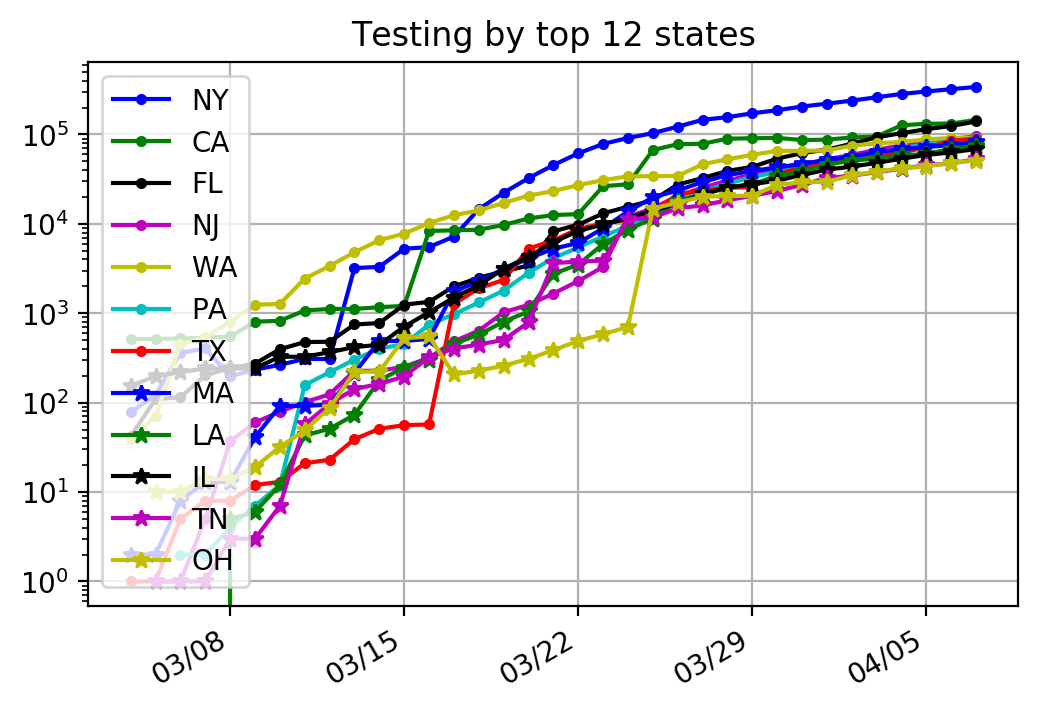

In [100]:
# get top 7 states (using  current)
fig,ax=plt.subplots(1,1,)
stFocused = dfStates.sort_values(by="total",ascending=False).head(12)["state"]
for st in stFocused:
    y = dfTStates[dfTStates["state"]==st].sort_values(by='date',ascending=True)["total"]
    
    ax.semilogy(y,label=st)

ax.xaxis.set_major_locator(myLocator)
ax.xaxis.set_major_formatter(myFmt)
ax.grid()
plt.legend()
fig.autofmt_xdate()
plt.title("Testing by top 12 states");
#dfTStates[(dfTStates["state"]=="CA") & (dfTStates["positive"]>100)]["positive"].index


positive rate 19.17%  423164
hospital rate 11.14%   47159
death rate     3.43%   14495


,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,...,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,Case Delta,Test Delta,NegRate%
date,,,,,,,,,,,,,,,,,,,,,
2020-04-08,56,423164,1766602,17228,43524.0,47159.0,9702.0,1013.0,4073.0,216.0,...,2189766,2189766,1874.0,1579.0,104734.0,30570.0,135304.0,30570.0,135304.0,80.675378
2020-04-07,56,392594,1661868,16557,39011.0,45580.0,9649.0,889.0,4007.0,233.0,...,2054462,2054462,1941.0,730.0,114842.0,31263.0,146105.0,31263.0,146105.0,80.890666
2020-04-06,56,361331,1547026,17292,27847.0,44850.0,6607.0,816.0,2921.0,187.0,...,1908357,1908357,1182.0,3788.0,117302.0,29023.0,146325.0,29023.0,146325.0,81.065859
2020-04-05,56,332308,1429724,17307,23061.0,41062.0,5497.0,762.0,612.0,193.0,...,1762032,1762032,1184.0,2851.0,111132.0,26553.0,137685.0,26553.0,137685.0,81.140638
2020-04-04,56,305755,1318592,15573,22158.0,38211.0,5207.0,587.0,656.0,193.0,...,1624347,1624347,1352.0,4071.0,193718.0,33767.0,227485.0,33767.0,227485.0,81.176744
2020-04-03,56,271988,1124874,61980,20418.0,34140.0,4686.0,502.0,605.0,193.0,...,1396862,1396862,1178.0,3258.0,96225.0,32889.0,129114.0,32889.0,129114.0,80.528642
2020-04-02,56,239099,1028649,62101,18796.0,30882.0,4264.0,458.0,574.0,186.0,...,1267748,1267748,1084.0,4065.0,89459.0,28283.0,117742.0,28283.0,117742.0,81.139864
2020-04-01,56,210816,939190,59669,17721.0,26817.0,3837.0,3445.0,561.0,186.0,...,1150006,1150006,954.0,3943.0,74989.0,26133.0,101122.0,26133.0,101122.0,81.668270
2020-03-31,56,184683,864201,59518,15591.0,22874.0,3402.0,2957.0,507.0,46.0,...,1048884,1048884,807.0,3890.0,79877.0,24153.0,104030.0,24153.0,104030.0,82.392429


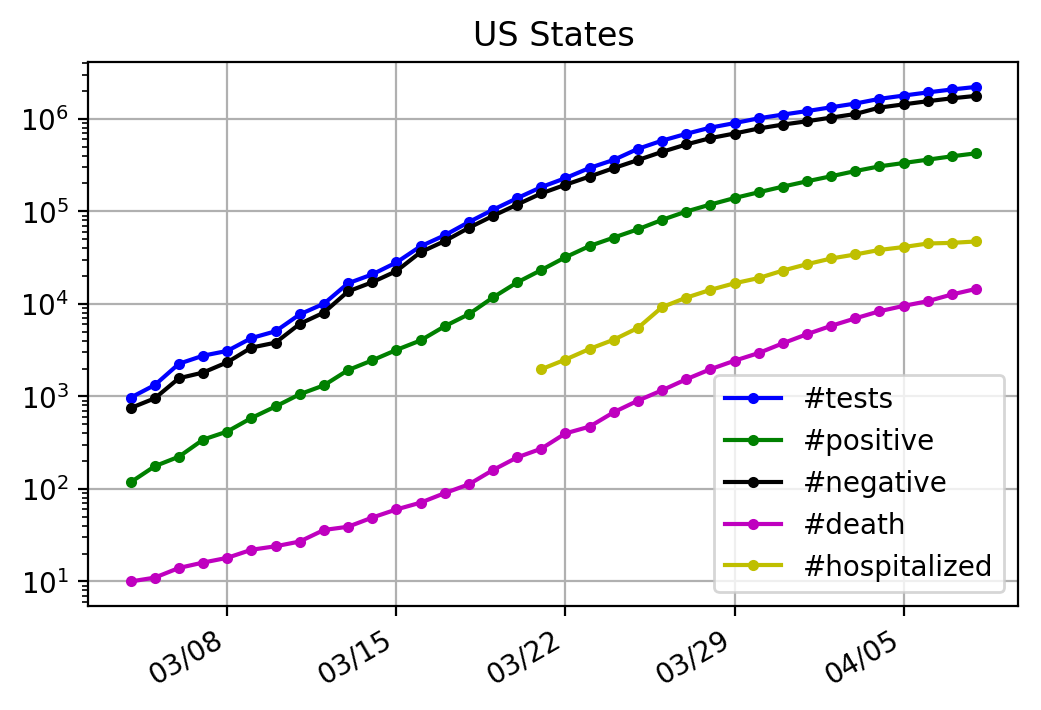

In [101]:
fig,ax = plt.subplots(1,1)
g= dfUST.sort_values(by="date",ascending=True)

ax.semilogy(g['total'],   label="#tests")
ax.semilogy(g['positive'],label="#positive")
ax.semilogy(g['negative'],label="#negative")
ax.semilogy(g['death'],   label="#death")
ax.semilogy(g['hospitalized'],   label="#hospitalized")

ax.xaxis.set_major_locator(myLocator)
ax.xaxis.set_major_formatter(myFmt)
ax.set_title("US States");
ax.grid()
plt.legend()
fig.autofmt_xdate()
print("positive rate %5.2f%% %7d" %((100*g['positive'][-1]/g['total'][-1])       ,g['positive'][-1]))
print("hospital rate %5.2f%% %7d" %((100*g['hospitalized'][-1]/g['positive'][-1]),g['hospitalized'][-1]))
print("death rate    %5.2f%% %7d" %((100*g['death'][-1]/g['positive'][-1])       ,g['death'][-1]))
dfUST

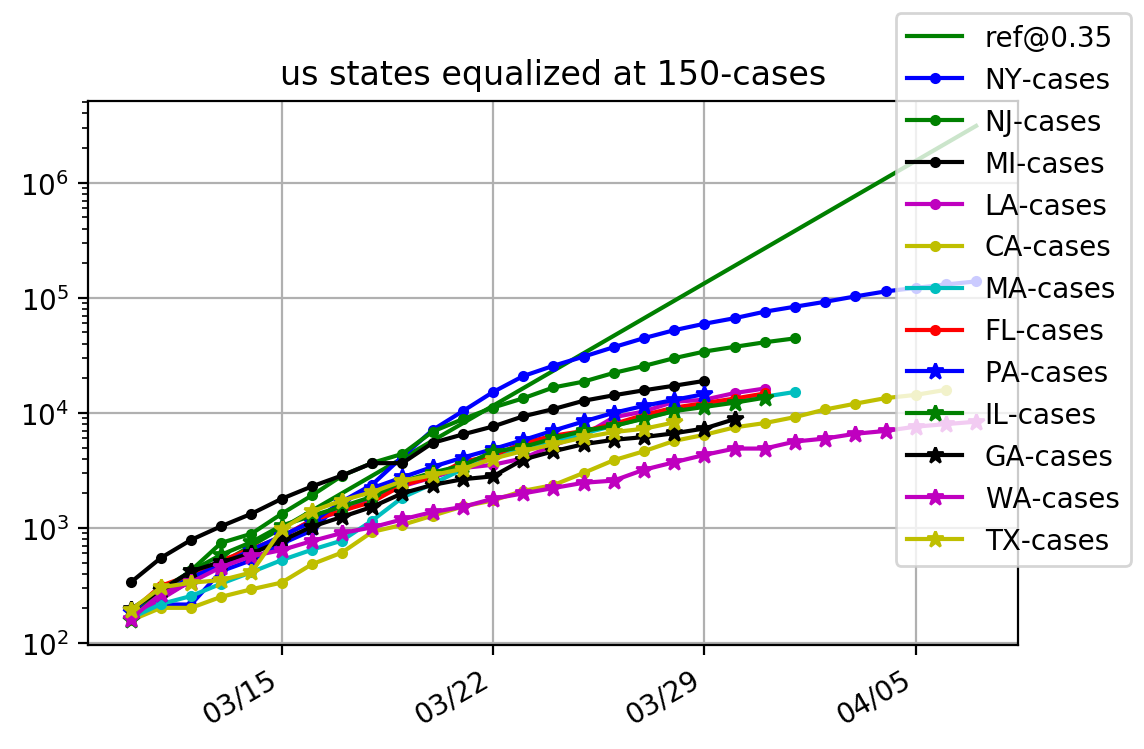

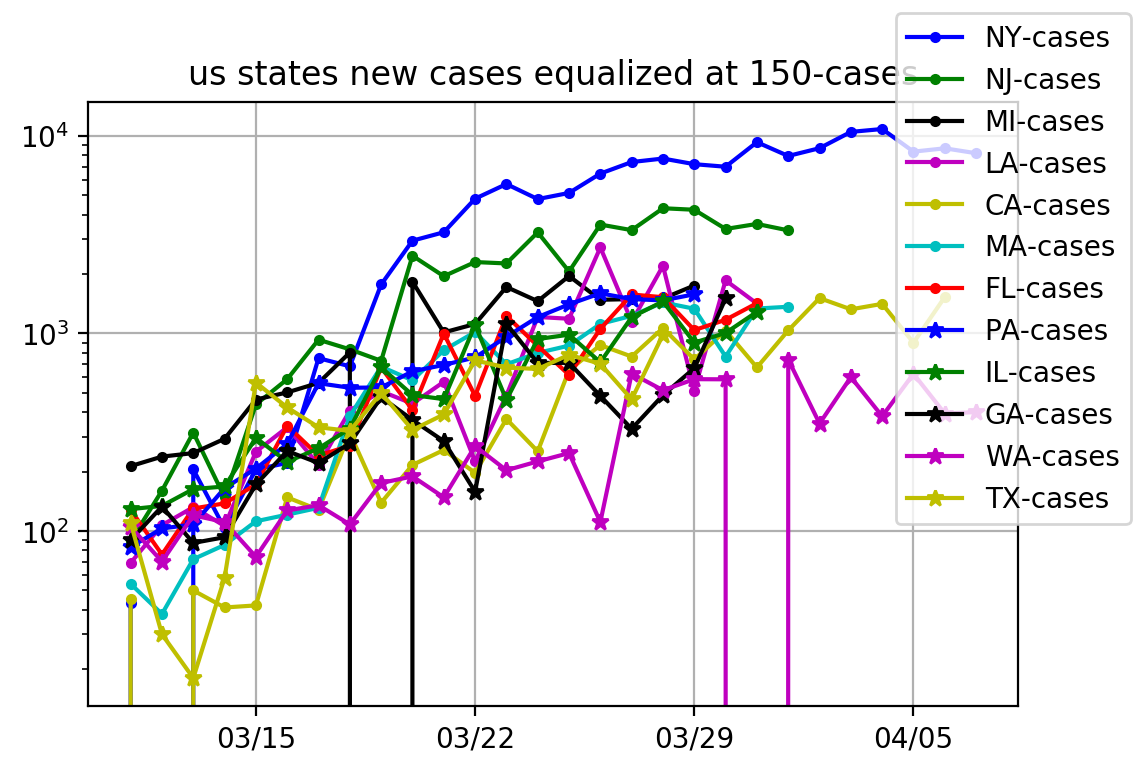

In [102]:
dfTStates.sort_values(by='date',ascending=True,inplace=True)

def food(state,rate,M,ax):
    y = dfTStates[(dfTStates["state"]==state) & (dfTStates["positive"]>M)]["positive"]
    y0=y[0]
    #start date
    dts = y.index[0]
    N=(dfTStates[(dfTStates["state"]==state)].index[-1] - dts).days+1
    x=np.arange(0,N);
    xdt = [dts +datetime.timedelta(days=d) for d in range(0,N)]
    ye = y0* np.exp(rate * x)
    
    return dts,xdt,ye

stFocused = dfStates.sort_values(by="positive",ascending=False).head(12)["state"]

fig,ax   = plt.subplots(1,1)
fig2,ax2 = plt.subplots(1,1)
#focused state
st="NY"
#number of ases
M=150
rate=0.35
[dts,xdt,ye] = food(st,rate,M,ax)
ax.semilogy(xdt,ye,'g-',label="ref@%.2f"%rate)



for idx in np.arange(0,12):
    g=dfTStates[dfTStates["state"]==stFocused.values[idx]]["positive"]
    y = g[g>M]
    N=sp.size(y)
    xdt = [dts +datetime.timedelta(days=d) for d in range(0,N)]
    lbl= "%s-cases"%stFocused.values[idx];
    ax.semilogy(xdt,y,label=lbl)
    ax2.semilogy(xdt[1:],np.diff(y),label=lbl)

ax.grid();                            ax2.grid()
ax.xaxis.set_major_locator(myLocator);ax2.xaxis.set_major_locator(myLocator)
ax.xaxis.set_major_formatter(myFmt)  ;ax2.xaxis.set_major_formatter(myFmt)
ax.set_title ("us states equalized at %d-cases"%M);
ax2.set_title("us states new cases equalized at %d-cases"%M);
fig.legend();                        fig2.legend()
fig.autofmt_xdate()
idx= 0


# Simple model 
## use exponentia, until inflection point of logistic curve

current count = previous count + E * p * previous count

or 

current count = (1 + E * p) * previous count

E = is average number of people someone infected is exposed to each day

p = propabatiity of each exposed ecoming an infection


# Smarter  model

Y' = A * sech^2( B * (t-C) )

Y = A/B * ( tanh( B * (t-C)) + 1 )

The equation for Y is just the integral of the equation for Y', where I have set the constant of integration to make the curve start at zero cases so far.

A = the peak infection rate (4600 case/day)

B = the width parameter (0.116)

C = the center date (2/6/2020 3AM)

sech z = 1/cosh z

       = 2/(e^z+e^-z)


 
# references

franklin antonio

https://royalsocietypublishing.org/doi/pdf/10.1098/rspa.1927.0118

 

The Epidemic Curve parts I & II, Wilson & Burke, 1942,1943

Proc Natl Acad Sci U S A. 1942 Sep; 28(9): 361–367

Proc Natl Acad Sci U S A. 1943 Jan; 29(1): 43–48

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078491/pdf/pnas01644-0025.pdf

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078553/pdf/pnas01648-0050.pdf


# predict the 'US' covid-19 number of illness

will adapt the rate, note this will only reflect the positive exponent of the logistic curver (at the inflection points switchs from exponential to logarithmic)

the positive exponent of the logistic curver (at the inflection points switchs from exponential to logarithmic)

https://en.wikipedia.org/wiki/Generalised_logistic_function

assuming a groth rate of 10%

where will the us be


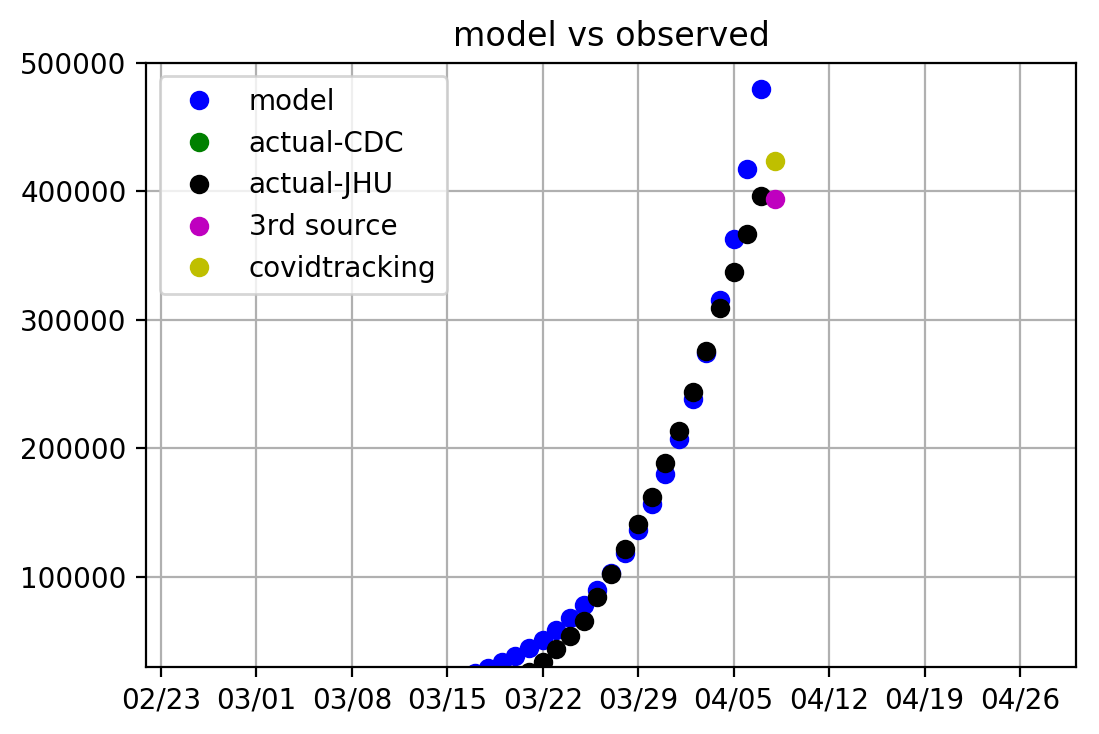

In [103]:
# 
# use JHU
# estimate US data

idx = pd.IndexSlice

#find cumulateive greater then 50, this will be y0
startDate = dataCdc[dataCdc>250].index[0]
rate = .14

#start from scratch take y[0] and assume X% groth and assume, y0 was 20% report of all reporting (multiply by 5)
# get number of samples in the data base
N = (datetime.date.today()-startDate).days

#project for another 2 week
NP = 20
NEC = (datetime.date.today()    -dataCdc.index[-1]).days-1
NEJ = (datetime.datetime.today()-dataJHU.columns[-1] ).days-1


# projection (assume multipler of 5)
yh = dataCdc[startDate] * 5 * np.exp(rate * np.arange(0,N+NP))
yh=yh.astype(int)

x = [startDate+datetime.timedelta(days=int(i)) for i in np.arange(0,N+NP)]
fig, ax = plt.subplots(1,1)

ax.plot_date(x,
             yh,
             label="model")
ax.plot_date(x[0:(N-NEC)],
             dataCdc[startDate:].values,
             label="actual-CDC")
ax.plot_date(x[0:(N-NEJ)],
             dataJHU.loc["US",startDate:].sum().values,
             label="actual-JHU")
ax.plot_date(datetime.date.today(),
             dataCS.loc[idx[:,:,:, "United States","country"],"cases"],
            label="3rd source")

ax.plot_date(datetime.date.today(),
        dataCovTr["positive"],
        label="covidtracking")
ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("model vs observed")
ax.set_ylim(3e4, 5e5)


yc = np.concatenate([dataCdc.loc[startDate:].values,
                     np.nan * np.ones(NP+NEC)])


yj = np.concatenate([dataJHU.loc["US",startDate:].sum().values,
                    np.nan * np.ones(NP+NEJ)])


if(1):
    df =pd.DataFrame({"model": yh,
                  "cdc"  : yc,
                  "jhu"  : yj},index=x)
    #print(df)


# predict the 'No-China' covid-19 number of illness


2020-03-07 00:00:00


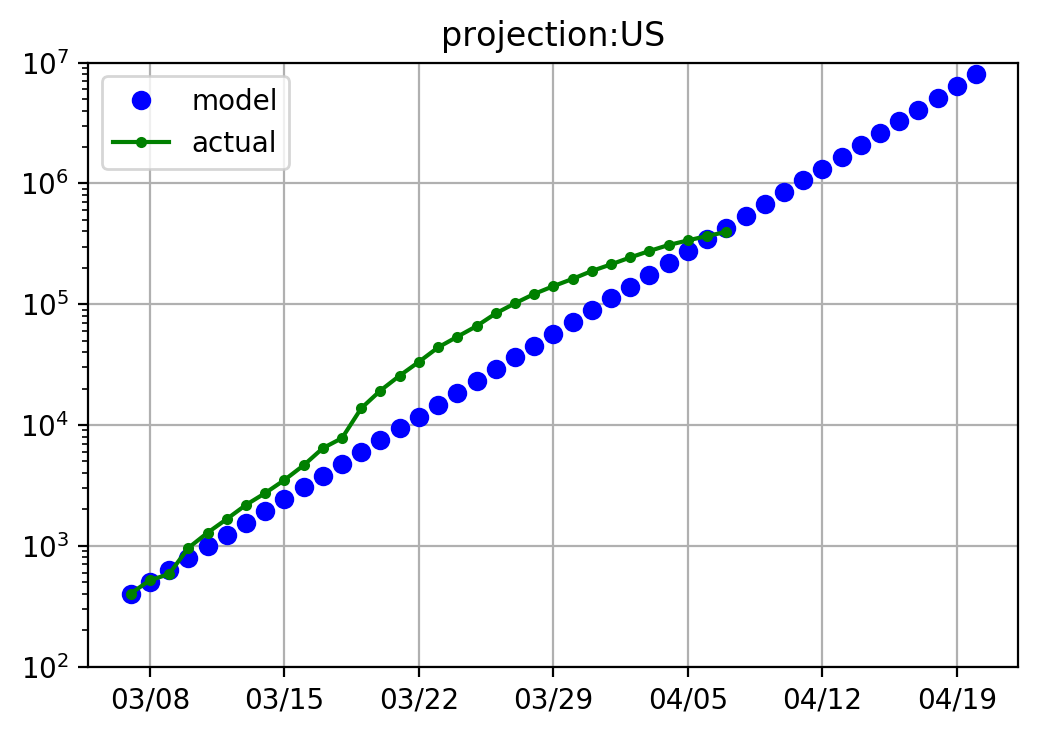

In [104]:


#start date
rate      = .225
ctr       = "US"
caseMin   = 300
TN        = 14    # number of intervals after today

s = dataJHU.loc[ctr].sum()
startDate = s[s>caseMin].index[0]

print(startDate)

#nmber of intervals
N  = sp.size(dataJHU.columns)


# Set the epoch value
Y0 = dataJHU[startDate][ctr].sum()
#determine time offset
offset = (dataJHU.columns[-1]-startDate).days
Yt =Y0 * sp.exp(rate * np.arange(0,offset + TN))

x = [startDate+datetime.timedelta(days=int(i)) for i in np.arange(0,offset + TN)]
NE = (datetime.datetime.today()-dataJHU.columns[-1] ).days


fig,ax = plt.subplots(1,1)
ax.plot_date(x,
             Yt,
             label="model")

ax.plot(dataJHU.loc[ctr,startDate:].sum(),
        label="actual")

ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("projection:%s"%ctr)
ax.set_ylim(1e2, 1e7)
plt.yscale('log')

# San Diego Data

also saves the data to create a time series

In [109]:
#script for scraping HTML sites 
# investigate  java scripts for cleaner solution, need to inspect and find source
import re,pickle, requests
try:
    from bs4 import BeautifulSoup
except ImportError:
    !pip install packaging
    from bs4 import BeautifulSoup


URL = 'https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')




table = soup.find("div",{"class":"table parbase section"})
rows = table.find_all('tr')
 
# handle header
header = [row.text for row in rows[1].find_all('td')]
header = [re.sub('[ \t\n]+', ' ',h)  for h in header]

tbl ={}
for row in rows[2:]: #skip the first row
    data = [r.text for r in row.find_all('td')]    
    if data[1] =='\xa0':continue    
    tbl[data[0]]=[int(d.replace(',','')) for d in data[1:]]
df = pd.DataFrame(tbl, index=header[1:])
display(HTML(df.to_html()))
updateDateTime = re.search("Table updated (.*? 2020)",rows[0].find('td').text)[1]
#updateDateTime = rows[0].find('td').text.split('\n')[-1].replace("Updated","")
print("last update is %s" % updateDateTime )

dt = datetime.datetime.strptime(updateDateTime.strip(),"%B %d, %Y")
# get data
data = pickle.load( open( "sandiego.tseries.p", "rb" ) )
if not dt in data.keys():
    print("saving new data, with key %s" %dt)
    data[dt] =df
    pickle.dump(data,open("sandiego.tseries.p",'wb'))

,Total Positives,0-9 years,10-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60-69 years,70-79 years,80+ years,Age Unknown,Female,Male,Unknown,Hospitalizations,Intensive Care,Deaths
San Diego County Residents,1530,10,16,244,301,268,278,201,123,86,3,737,785,8,316,122,36


last update is April 8, 2020
saving new data, with key 2020-04-08 00:00:00


growht rate   :14.40%
hospital rate :20.65%
ICU rate      :7.97%
death rate    :2.35%


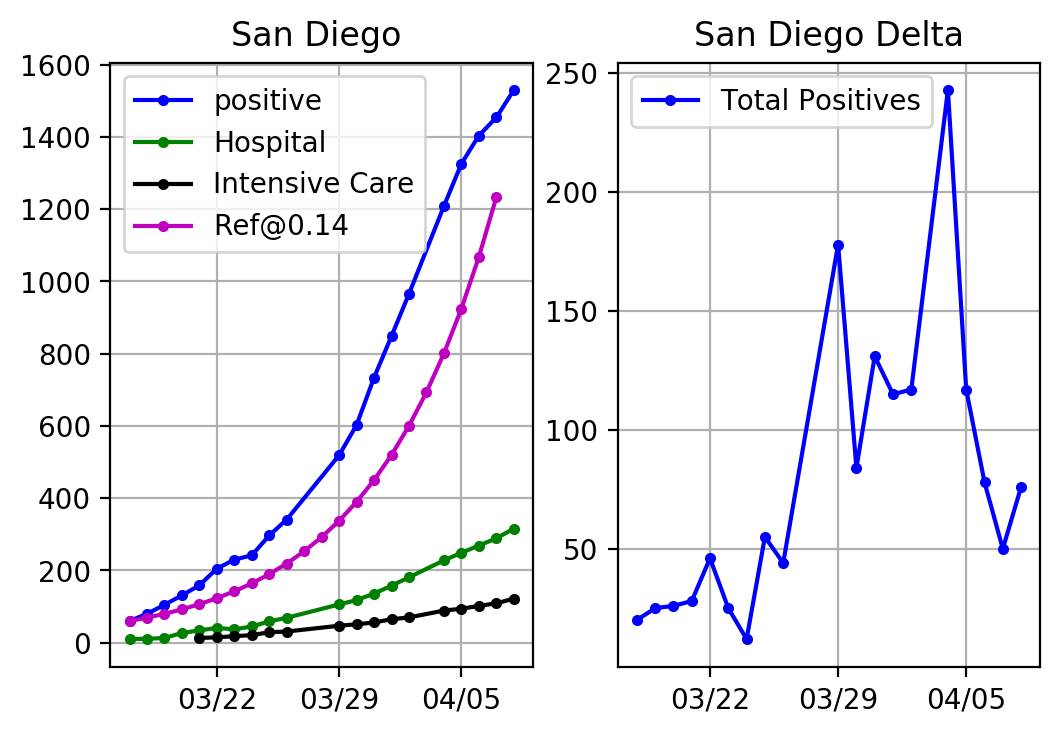

In [110]:
data = pickle.load(open("sandiego.tseries.p",'rb'))
columns = list(data.values())[-1].columns
dataSD = pd.DataFrame(columns=columns)


idx=0
for k in data.keys(): 
    df= data[k]
    ki = "Total" if "Total" in df.index else "San Diego County Residents"
    #print("%s = %d" % (k.date(),df["Total Positives"][ki]))
    d = df.loc[ki].to_dict()
    for kk in d.keys():        
        dataSD.loc[idx,kk]= d[kk]
    dataSD.loc[idx,"Date"]=k
    idx+=1;
# combine two hospitalized columns
dataSD['Hospitalizations'].fillna(dataSD['Hospitalized'],inplace=True)


fig,ax=plt.subplots(1,2)
ax[0].plot(dataSD["Date"],dataSD["Total Positives"], label="positive")
ax[0].plot(dataSD["Date"],dataSD["Hospitalizations"],label="Hospital")
ax[0].plot(dataSD["Date"],dataSD["Intensive Care"],  label="Intensive Care")


ts = [(dataSD["Date"][0] + datetime.timedelta(i)) for i in range(0,(dataSD["Date"].iloc[-1]-dataSD["Date"].iloc[0]).days)]
rate = np.log10(dataSD["Total Positives"].values[-1]-dataSD["Total Positives"].values[0]) / ((dataSD["Date"].values[-1]  - dataSD["Date"].values[0])/np.timedelta64(1, 'D'))
ax[0].plot(ts,dataSD["Total Positives"][0] * np.exp(rate*np.arange(0,sp.size(ts))),          label="Ref@%.2f"%rate)
setupAxis(ax[0],"San Diego ")

ax[1].plot(dataSD["Date"],dataSD["Total Positives"].diff())
setupAxis(ax[1],"San Diego Delta")

print("growht rate   :%.2f%%"% (rate * 100))
print("hospital rate :%.2f%%" %(100*dataSD['Hospitalizations'].iloc[-1]/dataSD['Total Positives'].iloc[-1]))
print("ICU rate      :%.2f%%" %(100*dataSD['Intensive Care'].iloc[-1]  /dataSD['Total Positives'].iloc[-1]))
print("death rate    :%.2f%%"    %(100*dataSD['Deaths'].iloc[-1]/dataSD['Total Positives'].iloc[-1]))

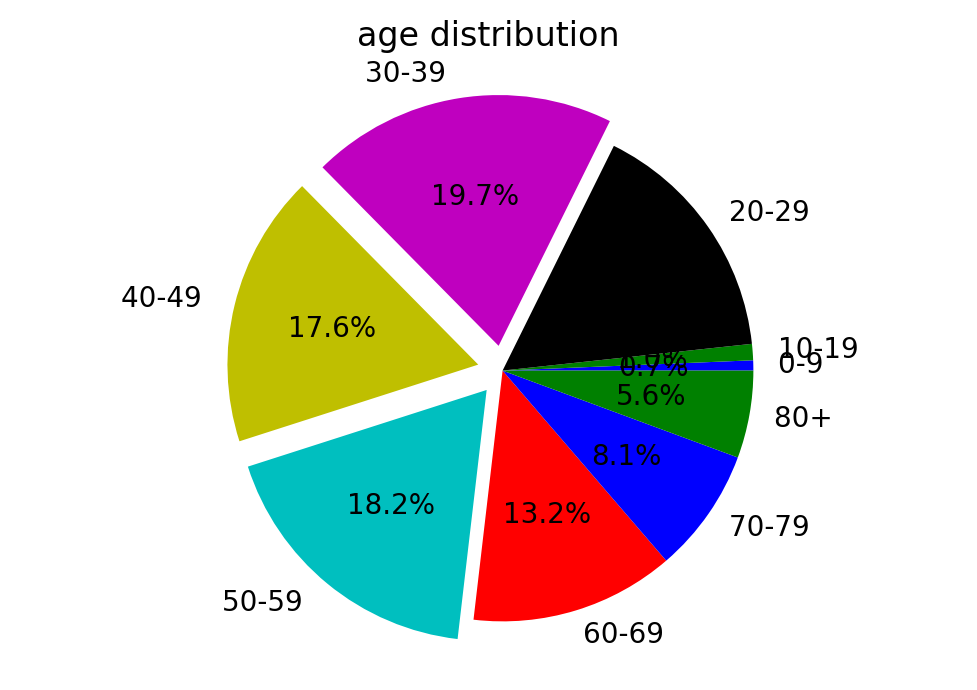

In [112]:
g = dataSD.filter(like="years",axis=1).iloc[-1].dropna()
fig1, ax1 = plt.subplots()
ax1.pie(g.values, 
        explode=(g/sum(g) * 100 >17)* .1,
        labels=g.index.str.replace("years",''), 
        autopct='%1.1f%%',)
ax1.axis('equal');
ax1.set_title("age distribution");
